In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np

In [29]:
x = torch.load('/pscratch/sd/k/kas7897/diffDownscale/jobs/miroc6-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/x.pt', weights_only = False).to('cpu').squeeze(-1).numpy()
y = torch.load('/pscratch/sd/k/kas7897/diffDownscale/jobs/miroc6-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/y.pt', weights_only = False).to('cpu').squeeze(-1).numpy()
xt = torch.load('/pscratch/sd/k/kas7897/diffDownscale/jobs/miroc6-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/ep40/xt.pt', weights_only = False)

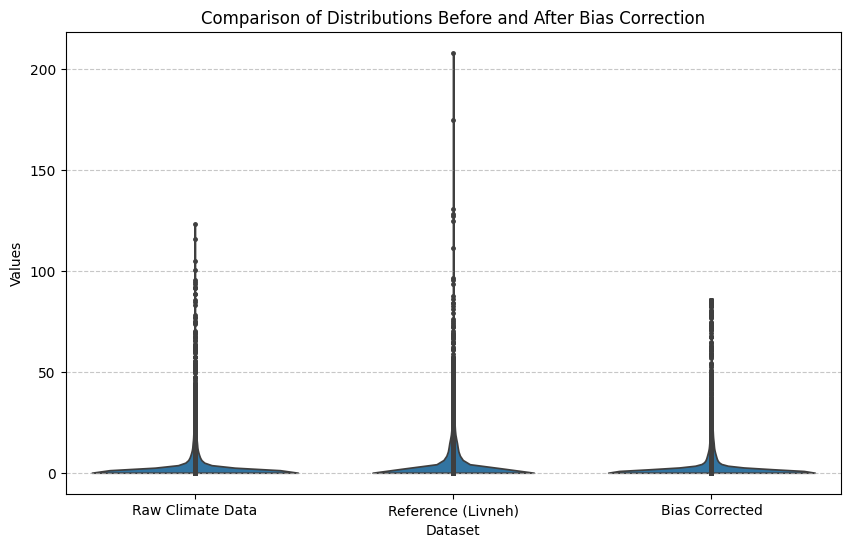

In [27]:
# Flatten the arrays
x_flat = x[:,0,0]
y_flat = y[:,0,0]
xt_flat = xt[:,0]

# Create a dataframe for visualization
df = pd.DataFrame({
    "Value": np.concatenate([x_flat, y_flat, xt_flat]),
    "Dataset": (["Raw Climate Data"] * len(x_flat)) + 
               (["Reference (Livneh)"] * len(y_flat)) + 
               (["Bias Corrected"] * len(xt_flat))
})

# Plot the beanplot (violin plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x="Dataset", y="Value", data=df, inner="point", cut=0)
plt.title("Comparison of Distributions Before and After Bias Correction")
plt.ylabel("Values")
plt.xlabel("Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

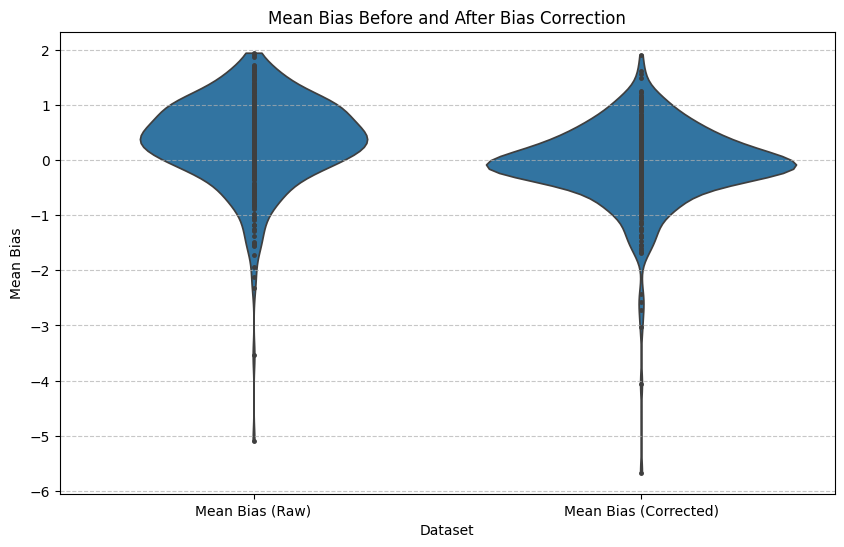

In [33]:
# Compute bias for each coordinate
bias_raw = np.mean(x - y, axis=0)  # Mean bias of raw data
bias_corrected = np.mean(xt - y, axis=0)  # Mean bias of corrected data

# Create a dataframe for visualization
df_bias = pd.DataFrame({
    "Bias Value": np.concatenate([bias_raw, bias_corrected]),
    "Type": (["Mean Bias (Raw)"] * len(bias_raw)) + (["Mean Bias (Corrected)"] * len(bias_corrected))
})

# Plot mean bias beanplot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Type", y="Bias Value", data=df_bias, inner="point", cut=0)
plt.title("Mean Bias Before and After Bias Correction")
plt.ylabel("Mean Bias")
plt.xlabel("Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

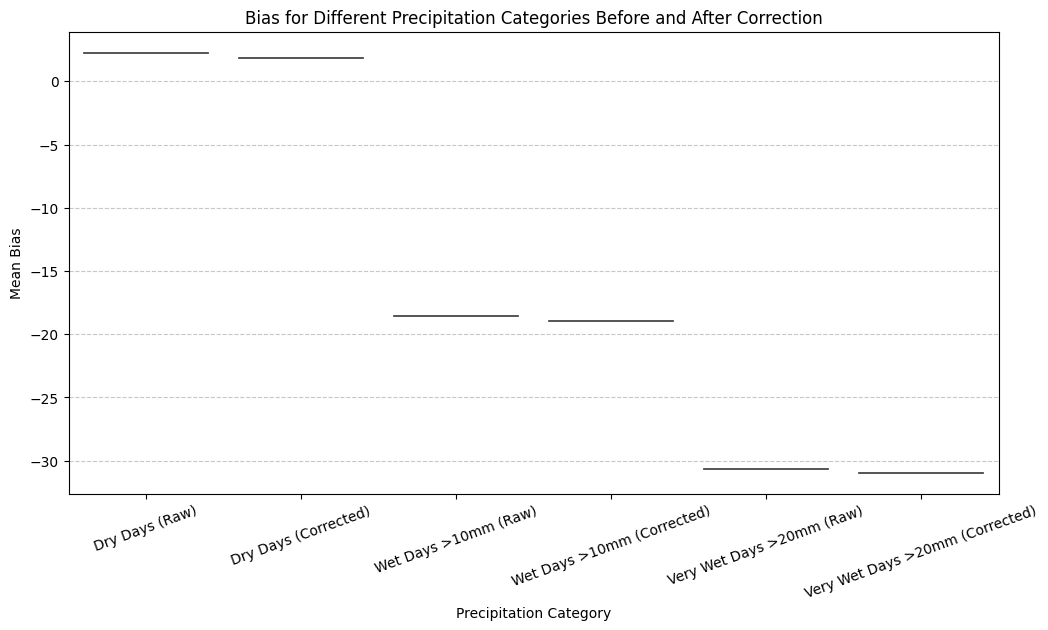

In [34]:
# Define thresholds
dry_threshold = 0  # Dry days (<= 0 mm)
wet_threshold = 10  # Wet days (>10 mm)
very_wet_threshold = 20  # Very wet days (>20 mm)

# Masked biases based on thresholds
dry_mask = y <= dry_threshold
wet_mask = y > wet_threshold
very_wet_mask = y > very_wet_threshold

# Function to safely compute mean bias while ensuring array output
def compute_mean_bias(mask, x, y, xt):
    if np.any(mask):  # Ensure there are valid values
        return np.atleast_1d(np.mean((x - y)[mask], axis=0)), np.atleast_1d(np.mean((xt - y)[mask], axis=0))
    else:
        return np.array([]), np.array([])

# Compute mean bias for each category
bias_dry_raw, bias_dry_corrected = compute_mean_bias(dry_mask, x, y, xt)
bias_wet_raw, bias_wet_corrected = compute_mean_bias(wet_mask, x, y, xt)
bias_very_wet_raw, bias_very_wet_corrected = compute_mean_bias(very_wet_mask, x, y, xt)

# Prepare lists for dataframe
bias_values = []
bias_types = []

# Add non-empty results to lists
for bias, label in [
    (bias_dry_raw, "Dry Days (Raw)"),
    (bias_dry_corrected, "Dry Days (Corrected)"),
    (bias_wet_raw, "Wet Days >10mm (Raw)"),
    (bias_wet_corrected, "Wet Days >10mm (Corrected)"),
    (bias_very_wet_raw, "Very Wet Days >20mm (Raw)"),
    (bias_very_wet_corrected, "Very Wet Days >20mm (Corrected)")
]:
    if bias.size > 0:
        bias_values.extend(bias.tolist())  # Ensure conversion to list
        bias_types.extend([label] * len(bias))

# Create dataframe
df_bias_categories = pd.DataFrame({
    "Bias Value": bias_values,
    "Type": bias_types
})

# Plot bias for different rainfall categories
plt.figure(figsize=(12, 6))
sns.violinplot(x="Type", y="Bias Value", data=df_bias_categories, inner="point", cut=0)
plt.title("Bias for Different Precipitation Categories Before and After Correction")
plt.ylabel("Mean Bias")
plt.xlabel("Precipitation Category")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()